In [1]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def select_rates(failure_type: str, resilience: int, node: int) -> pd.DataFrame:
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce_correct.db')

    # 统计resilience=1中且workflow_finish=1的作业占比
    query = f"""
    SELECT task_success_rate
    FROM workflow
    WHERE resilience={resilience}
    AND failure_type = '{failure_type}'
    AND makespan IS NOT NULL
    AND failure_rate_set=1
    AND node_cnt={node}
    """
    
    # Load data into a DataFrame
    df = pd.read_sql_query(query, conn)
    average_task_success_rate = df['task_success_rate'].mean()
    task_success_rate_sem = df['task_success_rate'].sem()


    query = f"""
    SELECT retry_success_rate
    FROM workflow
    WHERE resilience={resilience}
    AND failure_type = '{failure_type}'
    AND makespan IS NOT NULL
    AND failure_rate_set=1
    AND node_cnt={node}
    """
    df = pd.read_sql_query(query, conn)
    average_retry_success_rate = df['retry_success_rate'].mean()
    retry_success_rate_sem = df['retry_success_rate'].sem()

    # Close the database connection
    conn.close()

    # print(f"Average task success rate for resilience {resilience}: {average_task_success_rate}")
    # print(f"Average retry success rate for resilience {resilience}: {average_retry_success_rate}")

    return (average_task_success_rate, task_success_rate_sem), (average_retry_success_rate, retry_success_rate_sem)


In [11]:
def plot_failure(failure_type: str):
    (task_success_rate_r, task_success_rate_r_sem), (retry_success_rate_r, retry_success_rate_r_sem) = select_rates(failure_type, 1, 3)
    (task_success_rate_nr, task_success_rate_nr_sem), (retry_success_rate_nr, retry_success_rate_nr_sem) = select_rates(failure_type, 0, 3)
    data = {
        'resilience': ['Resilient', 'Resilient', 'Non-Resilient', 'Non-Resilient'],
        'rate_type': ['Task Success Rate', 'Retry Success Rate', 'Task Success Rate', 'Retry Success Rate'],
        'rate': [task_success_rate_r, retry_success_rate_r, task_success_rate_nr, retry_success_rate_nr]
    }
    data = {
        'resilience': ['Parsl with WRATH', 'Parsl with WRATH', 'Parsl without WRATH', 'Parsl without WRATH'],
        'rate_type': ['Task success rate', 'Retry success rate', 'Task success rate', 'Retry success rate'],
        'rate': [task_success_rate_r, retry_success_rate_r, task_success_rate_nr, retry_success_rate_nr],
        'sem': [task_success_rate_r_sem, retry_success_rate_r_sem, task_success_rate_nr_sem, retry_success_rate_nr_sem]
    }


    df = pd.DataFrame(data)
    print(df)

    # sns.set_palette("pastel")
    pastel_palette = sns.color_palette("pastel")
    blue_color = pastel_palette[0]  # 蓝色
    orange_color = pastel_palette[1]  # 橙色
    custom_palette = {
        'Parsl with WRATH': orange_color,
        'Parsl without WRATH': blue_color
    }
    sns.set_style("whitegrid")

    plt.rc('font', size=10)  # 控制默认文本的大小
    plt.rc('axes', titlesize=10)  # 控制标题的大小
    plt.rc('axes', labelsize=10)  # 控制x轴和y轴标签的大小
    plt.rc('xtick', labelsize=10)  # 控制x轴刻度的大小
    plt.rc('ytick', labelsize=10)  # 控制y轴刻度的大小
    plt.rc('legend', fontsize=10)  # 控制图例的字体大小

    # 绘制条形图
    plt.figure(figsize=(4, 2.4))
    ax = sns.barplot(data=df, x='rate_type', y='rate', hue='resilience', dodge=True, palette=custom_palette)

    # for i, bar in enumerate(ax.patches):
    for i, bar in enumerate(ax.patches[:len(df)]):
        ax.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=df['sem'].iloc[i], fmt='none', c='black', capsize=5)


    # 设置标签和标题
    ax.set_xlabel('')
    ax.set_ylabel('Success rate')
    ax.set_ylim(0, 1)
    # if failure_type == "memory":
    #     ax.set_ylim(0, 1.2)
    # else:
    #     ax.set_ylim(0, 1)

    # 获取当前图例
    handles, labels = plt.gca().get_legend_handles_labels()

    new_labels = ['Parsl with WRATH', 'Parsl without WRATH']

    # 绘制图例并设置新的标签
    plt.legend(handles, new_labels)
    # plt.legend(title='Failure Type', title_fontsize='12', fontsize='12')


    plt.tight_layout()
    plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/resolvable_{failure_type}.pdf')

    plt.show()


            resilience           rate_type      rate       sem
0     Parsl with WRATH   Task success rate  0.745322  0.033763
1     Parsl with WRATH  Retry success rate  0.470165  0.059145
2  Parsl without WRATH   Task success rate  0.240816  0.059642
3  Parsl without WRATH  Retry success rate  0.000000  0.000000


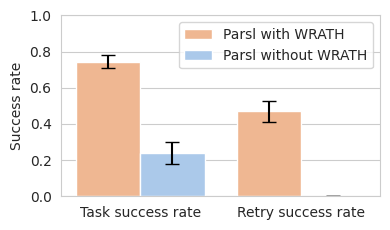

In [12]:
plot_failure('memory')

            resilience           rate_type      rate       sem
0     Parsl with WRATH   Task success rate  0.531762  0.029901
1     Parsl with WRATH  Retry success rate  0.433333  0.022208
2  Parsl without WRATH   Task success rate  0.220000  0.029180
3  Parsl without WRATH  Retry success rate  0.000000  0.000000


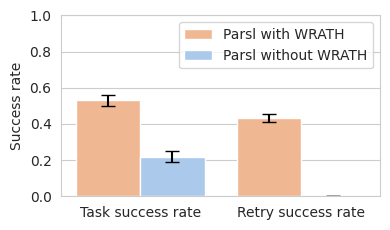

In [13]:
plot_failure('import')